In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.feature_column as fc 
import tensorflow.debugging as tfdbg
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/train.flat.csv", dtype={'fullVisitorId': 'str', 'visitId': 'str'})
df_t = pd.read_csv("data/test.flat.csv", dtype={'fullVisitorId': 'str', 'visitId': 'str'})
for col in df.columns:
#     print(col, df[col].fillna('').nunique())
    if df[col].fillna('').nunique() == 1:
        print("column skipped (cardinality = 1):", col)
        df = df.drop(col, axis=1)

column skipped (cardinality = 1): device.mobileDeviceInfo
column skipped (cardinality = 1): device.browserVersion
column skipped (cardinality = 1): totals.visits
column skipped (cardinality = 1): geoNetwork.networkLocation
column skipped (cardinality = 1): device.screenResolution
column skipped (cardinality = 1): geoNetwork.longitude
column skipped (cardinality = 1): geoNetwork.latitude
column skipped (cardinality = 1): device.flashVersion
column skipped (cardinality = 1): device.language
column skipped (cardinality = 1): trafficSource.adwordsClickInfo.criteriaParameters
column skipped (cardinality = 1): device.screenColors
column skipped (cardinality = 1): device.mobileDeviceModel
column skipped (cardinality = 1): socialEngagementType
column skipped (cardinality = 1): device.operatingSystemVersion
column skipped (cardinality = 1): device.mobileInputSelector
column skipped (cardinality = 1): device.mobileDeviceBranding
column skipped (cardinality = 1): geoNetwork.cityId
column skipped 

In [3]:
sdf = pd.DataFrame()
sdf_t = pd.DataFrame()
features = []

# boolean
for col in ['trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd', 'device.isMobile', 'totals.newVisits']:
    sdf[col] = df[col].apply(lambda x: 2 if np.isnan(x) else int(x))
    sdf_t[col] = df_t[col].apply(lambda x: 2 if np.isnan(x) else int(x))
    features.append(fc.indicator_column(fc.categorical_column_with_vocabulary_list(col, (0,1,2))))
        
# numeric
for col in ['visitNumber', 'visitStartTime', 'date', 'totals.hits', 'totals.pageviews']:
    minv = df[col].min()
    maxv = df[col].max()
    sdf[col] = df[col].apply(lambda x: (x-minv)/maxv).fillna(0)
    sdf_t[col] = df_t[col].apply(lambda x: (x-minv)/maxv).fillna(0)
    features.append(fc.numeric_column(col))

    
from sklearn.preprocessing import LabelEncoder
    
# string
for col in [
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.page',
    'channelGrouping',
    'geoNetwork.region',
    'geoNetwork.country',
    'geoNetwork.metro',
    'trafficSource.campaign',
    'totals.bounces',
    #'trafficSource.referralPath',
    'device.deviceCategory',
    'device.browser',
    'trafficSource.adContent',
    'trafficSource.medium',
    'geoNetwork.city',
    'trafficSource.source',
    'trafficSource.adwordsClickInfo.slot',
    'fullVisitorId',
    'geoNetwork.subContinent',
    'device.operatingSystem',
    #'geoNetwork.networkDomain',
    'trafficSource.adwordsClickInfo.gclId',
#     'trafficSource.campaignCode', // not exist in test
    'trafficSource.keyword',
    'geoNetwork.continent']:
    le = LabelEncoder()
    le.fit(pd.concat([df[col].astype(str).fillna(''), df_t[col].astype(str).fillna('')]))
    sdf[col] = le.transform(df[col].astype(str).fillna(''))
    sdf_t[col] = le.transform(df_t[col].astype(str).fillna(''))
    features.append(fc.indicator_column(fc.categorical_column_with_vocabulary_list(col, sdf[col].unique())))

10000.0 23129500000.0
17.823362302985537


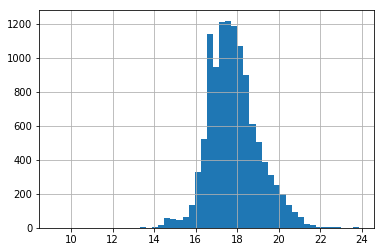

In [11]:
print(df['totals.transactionRevenue'].dropna().min(), df['totals.transactionRevenue'].dropna().max())
label = np.log(df['totals.transactionRevenue'].dropna() + 1)
print(label.mean() )
label.hist(bins=50)

In [5]:
print(sdf['trafficSource.campaign'].unique())

[ 4  9 13 10 34  7 27  8 11 12]


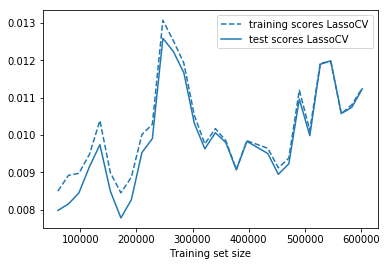

In [6]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn import linear_model

est = linear_model.LassoCV(n_alphas=20)
training_set_size, train_scores, test_scores = learning_curve(est, sdf, label, train_sizes=np.linspace(0.1, 1, 30))
estimator_name = est.__class__.__name__
line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())
plt.xlabel('Training set size')
plt.legend(loc='best')

In [7]:
est.fit(sdf, label)
pre = est.predict(sdf_t)
len(pre) 

804684

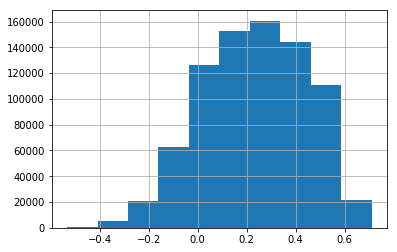

In [8]:
pre
pre = pd.Series(pre)
pre.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1271e9208>]],
      dtype=object)

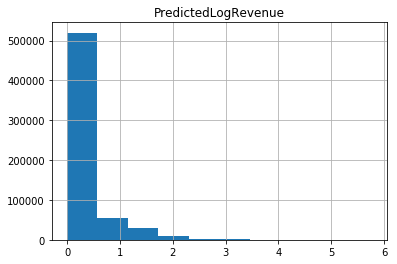

In [9]:
ans = pd.DataFrame()
ans['fullVisitorId'] = df_t['fullVisitorId'].astype(str)
ans['PredictedLogRevenue'] = np.exp(pre) # np.log(pre)
ans = ans.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
ans.columns = ["fullVisitorId", "PredictedLogRevenue"]
ans['PredictedLogRevenue'] = np.log(ans['PredictedLogRevenue']).apply(lambda x: max(x, 0))
ans.to_csv('data/ans.csv', index=False)
ans.hist()
